### Notebook submitted by Julián Ferreiro (NetID:jif245)

The goal is to assess whether the location of the [linkNYC](https://www.link.nyc/) access points is optimal to guarantee a more "democratic" access to the internet.

## THE CENSUS: 
The 1 year survey data is what we will use: https://www.census.gov/services/index.html


# 1. PUMA : Public Use Microdata Area
PUMAs are geographical areas designed to aggregate census data. Each PUMA contains at least 100,000 people. PUMAs do not overlap, and are contained within a single state. 

## 1.1 download the NYC  Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas

https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty/data

download it as a shape file. When you download a shapefile you actually download a zipped folder which contains the shape file and other files that are necessary to read the shape file in. You can do that with the urllib library in python 3 with the function 

        urllib.request.urlretrieve(url, "file.gz")

then unpack the data into your PUIdata directory, then read it in with geopandas, reading in the shape file with the function 

        geopandas.GeoDataFrame.from_file(filename)

In [1]:
#importing packacges for future use
import os
import geopandas as gp
import urllib
import zipfile
import requests
import json
import pandas as pd
import io


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# check for PUIdata env var
PUIdata = os.getenv("PUIDATA")
"The path to the PUIdata directory is " + PUIdata

'The path to the PUIdata directory is /home/cusp/jif245/PUIdata'

In [3]:
#We download the shapefile to our current working directory (uncomment to download)
urllib.urlretrieve("https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile",PUIdata+"/puma.gz")

('/home/cusp/jif245/PUIdata/puma.gz',
 <httplib.HTTPMessage instance at 0x7fea211c90e0>)

In [4]:
#we unzip
zip_ref = zipfile.ZipFile(PUIdata+"/puma.gz", 'r')
zip_ref.extractall(PUIdata)
zip_ref.close()

Since each time it downloads the puma.gz is has a different code number (i.e geo_export_XXXXXXX.shp, XXXX changes, we need a way to open the file that ignores the code:

In [5]:
#reading the shape file into a data frame

#glob allows the use of wildcards
import glob
thefileiwant=glob.glob(PUIdata+"/geo_export_*.shp") #this creates a LIST object with the name of the shape files in my directory
                                           #(I only have one)
print thefileiwant
pumashp=gp.GeoDataFrame.from_file(thefileiwant[0])

['/home/cusp/jif245/PUIdata/geo_export_c60628a6-9f5c-4380-ab2c-c115734f300c.shp', '/home/cusp/jif245/PUIdata/geo_export_a45696d5-fb5a-49f4-a632-6378e7854436.shp', '/home/cusp/jif245/PUIdata/geo_export_fe9ac672-3b51-4314-a6cc-687af741b2c9.shp']


In [6]:
#Visualizing what we imported
pumashp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


PUMAs are identified by a specific 4 numbers id (first column)

In [7]:
#Converting coordinate system. We want consistency between our maps
pumashp.crs

{'init': u'epsg:4326'}

## 1.2  plot the PUMA NYC regions

We will draw the contours of the region using a function choroplethNYC.

The function was developed by Federica Bianco and can be found here:
https://github.com/fedhere/choroplethNYC

In [8]:
#As mentioned, for the following section it is necessary to download a function found here:
urllib.urlretrieve("https://raw.githubusercontent.com/fedhere/choroplethNYC/master/choroplethNYC.py","choroplethNYC.py")

('choroplethNYC.py', <httplib.HTTPMessage instance at 0x7fe9dc512bd8>)

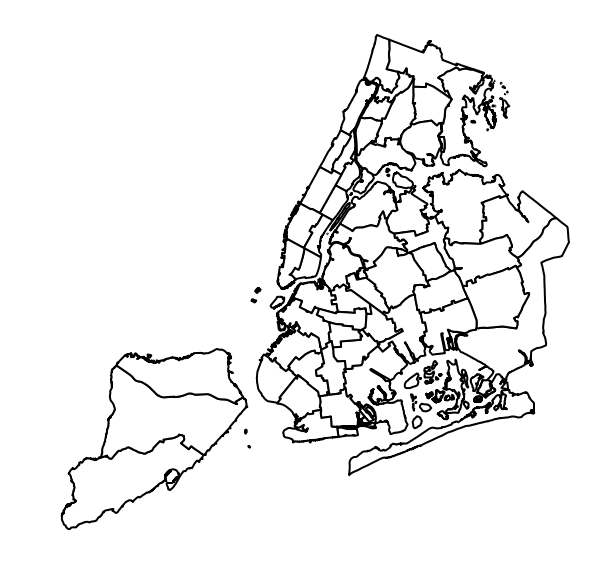

In [9]:
# using a choroplethNYC function that FBB wrote
import choroplethNYC as cp
cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=2);

Figure 1. Contours of the PUMAs in NYC.

# 2. American Fact Finder data on percentage of houses with broadband internet access

## 2.1 Get data with American Fact Finder (AFF) API: 

In [10]:
#reading in my api key saved in censusAPI.py
from censusAPI import myAPI

In [11]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [12]:
#turning things into arrays to enable broadcasting (works in Python 2 only)
affkeys = np.array(aff1y['variables'].keys())

We need two features: **total number of households**, and **number of households with broadband access**

Broadband access is one of the B28002 keys.
We will check the rows that start with "B28002"and have  "Broadband" in the description.  

In [13]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[(u'B28002_008E',
  u'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 (u'B28002_008M',
  u'Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 (u'B28002_004MA',
  u'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 (u'B28002_008MA',
  u'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 (u'B28002_004E',
  u'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 (u'B28002_004M',
  u'Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 (u'B28002_007MA',
  u'Annotation of Ma

Note that **B28002_004E** stands for "Estimate!!Total!!With an Internet subscription!!Broadband of any type". 
This is what we will use. 

Below we select the variable containing the number of household per PUMA. 
The "all" variable, which tells you what is the total number of units queried (households here) is stored in the \_001 variable (B28002_001 in this case). 

"E" stands for *estimate* and is what we will use in this excersice.

Afterwards we select the keyword for houses with broadband of any type

In [14]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{u'attributes': u'B28002_001M,B28002_001EA',
 u'concept': u'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 u'group': u'B28002',
 u'label': u'Estimate!!Total',
 u'limit': 0,
 u'predicateType': u'int',
 u'validValues': []}

In [15]:
#keyword for the number of households with broadband access
keyNBB = "B28002_004E"
aff1y['variables'][keyNBB]

{u'attributes': u'B28002_004M,B28002_004EA',
 u'concept': u'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 u'group': u'B28002',
 u'label': u'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 u'limit': 0,
 u'predicateType': u'int',
 u'validValues': []}

Now we can use the keys to extract the relevant data with the ACS API. 

To request the right geometry we need to use: "public%20use%20microdata%20area" where %20 is the character for ' ' (space) in a url, and ":\*" means all PUMAS, and state:36 is New York State

In [16]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [17]:
#getting the first row of the table: the total number of households with broadband internet
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))


In [18]:
pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 2.2 generate a feature for the percentage of households with broadband access

In [19]:
#To get this, we divide the number of houses with broadband access with the number of households
pumaBB["pcBB"]=pumaBB["B28002_004E"]/pumaPP["B28002_001E"]
del pumaBB["Unnamed: 4"] #we erase unnecesary columns
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,0.805529
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,0.757333
2,41210,"Warren & Washington Counties PUMA, New York",36,300,0.798427
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,0.814334
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,0.781507


## 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above

We manually download the GCT Geographic Comparison Tables for the same characteristics from:
https://factfinder.census.gov/ 

The file was moved to PUIdata directory, unzip it and load it with pandas.

The following code reads the CSV, which was already unzipped from the file.

In [20]:
#We read the unzipped csv
bbpc= pd.read_csv(PUIdata+"/ACS_16_1YR_GCT2801.ST50_with_ann.csv",usecols=["Target Geo Id2","Percent","Margin of Error"],skiprows=[0])
bbpc.head()

,Target Geo Id2,Percent,Margin of Error
0,36,81.7,0.2
1,3600100,80.6,2.6
2,3600200,75.7,2.2
3,3600300,79.8,2.6
4,3600401,81.4,2.4


To make the PUMA id consistent, we need to substract 360000 from the ID number in this dataframe
First we check the data type of each column:

In [21]:
#checking types of data for the PUMA ID
print (type(bbpc["Target Geo Id2"][2]))
print (type(pumaBB["public use microdata area"][2]))

<type 'numpy.int64'>
<type 'numpy.int64'>


In [22]:
#we rename the columns for consistency
bbpc.columns=["gid","Percent","error"]

In [23]:
#we rename the columns for consistency
pumaBB.columns=[u'B28002_004E', u'NAME', u'state', u'gid',u'pcBB']

In [24]:
#we substract the number to make the ID equal
bbpc["gid"]=bbpc["gid"]-3600000

In [25]:
#now that the IDs are equal, we can merge them
diff_=pd.merge(pumaBB,bbpc,on="gid")[["pcBB", "Percent"]]

In [26]:
diff_.head()

,pcBB,Percent
0,0.805529,80.6
1,0.757333,75.7
2,0.798427,79.8
3,0.814334,81.4
4,0.781507,78.2


## check that the percentage of households with broadband you generated and the one you red in from the table you downloaded manually are the same

In [27]:
diff_["diff"] = np.abs(diff_["pcBB"] - (diff_["Percent"]/100.0).astype(float))

diff_.describe()

,pcBB,Percent,diff
count,145.000000,145.000000,145.000000
mean,0.818455,81.843448,0.000262
std,0.070634,7.065358,0.000145
min,0.549329,54.900000,0.000002
25%,0.777703,77.800000,0.000123
50%,0.828261,82.800000,0.000272
75%,0.873051,87.300000,0.000391
max,0.934041,93.400000,0.000499


The maximum difference is off only by a few percent.  
We now feel more confident in our data processing.   
We stop a minute to congratulate ourselves.  

# 3 Plot a choropleth of NYC broadband access 
## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [28]:
#checking type
print (type(pumashp.puma[2]))

<type 'unicode'>


In [29]:
#we change the type to integer
pumashp.puma=pumashp.puma.apply(int)

In [30]:
#we can now merge the data between the percentage of households and the geodataframe
pumashp = pumashp.merge(bbpc,left_on="puma",right_on="gid")

In [31]:
pumashp.head()

,puma,shape_leng,shape_area,geometry,gid,Percent,error
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,3701,84.3,2.6
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,3702,68.3,3.7
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,3703,82.8,3.2
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",3704,72.6,3.6
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,3705,69.4,3.2


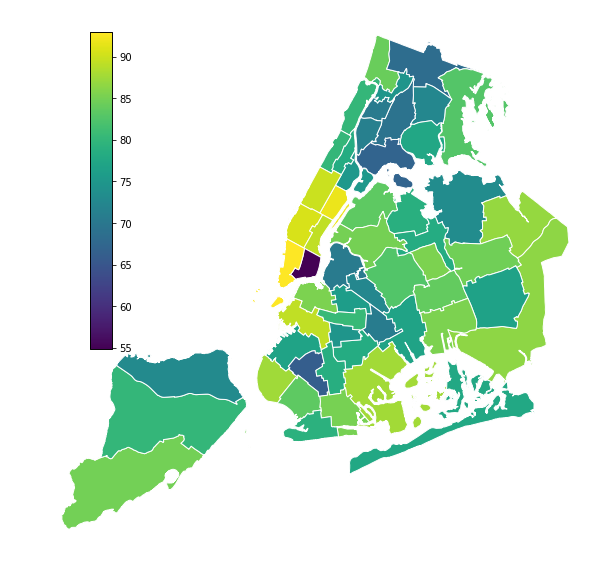

In [32]:
#plotting 
cp.choroplethNYC(pumashp, column="Percent", color="white",cmap="viridis", edgecolor="white", lw=1);

Figure 2. Map of New York City, divided by P.U.M.A. Color indicates percentage of population with access to broadband internet.
Note that manhattan has a higher percentage of households with broadband access. Yet another variable that seems to correlate with income. The ir also what seems like an outlier in SW Manhattan. What could that be?

# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

In [33]:
#acquiring files from Federica's github:
linkNYC=pd.read_csv("https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv")

In [34]:
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [35]:
#just checking
linkNYC.shape

(1414, 5)

In [36]:
#we we'll need new packages for the following steps
import shapely
from fiona.crs import from_epsg

In [37]:
# combine lat and lon to one column
linkNYC['lonlat']=zip(linkNYC.longitude,linkNYC.latitude)

In [38]:
# Create Point Geometry for based on lonlat column
linkNYC['geometry']=linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [39]:
#set native coordinates frame to lat/lon 
linkNYC_ = gp.GeoDataFrame(linkNYC)
linkNYC_.crs = from_epsg(4326)
linkNYC_.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat,geometry
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [40]:
pumashp.head()

,puma,shape_leng,shape_area,geometry,gid,Percent,error
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,3701,84.3,2.6
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,3702,68.3,3.7
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,3703,82.8,3.2
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",3704,72.6,3.6
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,3705,69.4,3.2


In [41]:
#my graphs were horrible, so I had to change the default parameteres
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 2.5

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


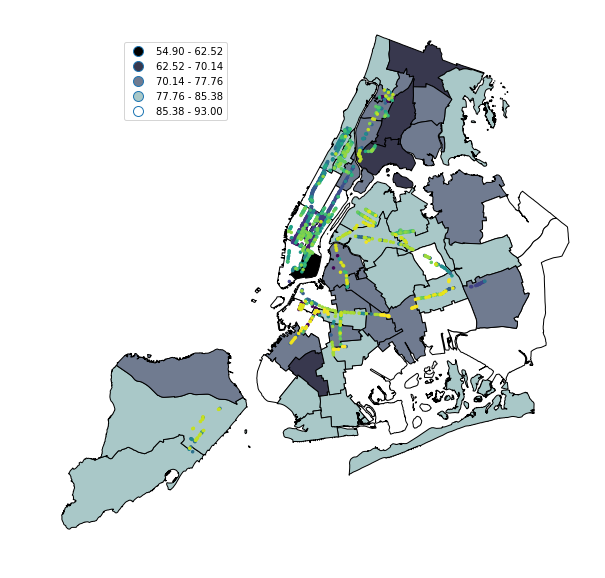

In [42]:
#plotting chloropeth and LINK stations
algo,eje,figurita=cp.choroplethNYC(pumashp, column="Percent", color="white",cmap="bone", edgecolor="black", scheme='equal_interval',k=5,lw=1)
cp.choroplethNYC(linkNYC_,ax=eje,cmap="viridis");


Figure 3. LinkNYC locations and broadband access percentage. Doesn't seem to be a correlation between stations and less broadband access. Almost looks that LinkNYC is concentrated in higher broadband/income areas and avoiding the ones with fewer (except for that outlier in Manhattan). LinkNYC wants data and probably, data from rich people if more valuable. Just guessing.

# 5 Find the number of linkNYC locations per person by PUMA

## 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

The ACS population by  variable is B00001_001E

In [43]:
#key for extracting total population
keyPop = "B00001_001E"
aff1y['variables'][keyPop]

{u'attributes': u'B00001_001EA',
 u'concept': u'UNWEIGHTED SAMPLE COUNT OF THE POPULATION',
 u'group': u'B00001',
 u'label': u'Estimate!!Total',
 u'limit': 0,
 u'predicateType': u'int',
 u'validValues': []}

In [44]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPop +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

In [45]:
pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [46]:
#we want only the relevant columns. We change the name for consistency
pumaPop=pumaPop[["B00001_001E","public use microdata area"]]
pumaPop.columns=["population","gid"]

In [47]:
#one more merge to the geodataframe
pumashp = pumashp.merge(pumaPop,left_on="gid",right_on="gid")

In [48]:
pumashp.head()

,puma,shape_leng,shape_area,geometry,gid,Percent,error,population
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,3701,84.3,2.6,1517
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,3702,68.3,3.7,1959
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,3703,82.8,3.2,1305
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",3704,72.6,3.6,1882
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,3705,69.4,3.2,2011


## 5.2 find the number of station per 100 people per PUMA

In [49]:
#convert coordinates for linkNYC
linkNYC_ = gp.GeoDataFrame(linkNYC)
linkNYC_.crs = from_epsg(2263)

In [50]:
#convert coordinates for pumashp 
pumashp = gp.GeoDataFrame(pumashp)
pumashp.crs = from_epsg(2263)

In [51]:
#create a geodataframe with a spatial join and use groupby to count the number of linkNYC in each PUMA
linkpp = gp.sjoin(pumashp,linkNYC_, how="left").groupby("gid").count() #"left" is for including data without LinkNYC
                                                                       # we don't want to loose pumas without LinkNYC

linkpp.head()

,puma,shape_leng,shape_area,geometry,Percent,error,population,index_right,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat
gid,,,,,,,,,,,,,,
3701,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3702,1,1,1,1,1,1,1,0,0,0,0,0,0,0
3703,1,1,1,1,1,1,1,0,0,0,0,0,0,0
3704,1,1,1,1,1,1,1,0,0,0,0,0,0,0
3705,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [52]:
#qw want only the counts and the gid, so we reset the index and then we transform the groupby into a viable dataframe for mergin
linkpp_=linkpp["puma"].reset_index()
linkpp_.columns=["gid","count_link"]

In [53]:
#merge back into the pumashp
pumashplc = pumashp.merge(linkpp_,left_on="gid",right_on="gid")

In [54]:
pumashplc.head()

,puma,shape_leng,shape_area,geometry,gid,Percent,error,population,count_link
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,3701,84.3,2.6,1517,1
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,3702,68.3,3.7,1959,1
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,3703,82.8,3.2,1305,1
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",3704,72.6,3.6,1882,1
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,3705,69.4,3.2,2011,1


In [55]:
#we create a new variable with links by 100 inhabitans.
pumashplc["linkNYCp100p"]=100*pumashplc.count_link/pumashplc.population

In [56]:
#linkNYC per 100 inhabitants
pumashplc["linkNYCp100p"].describe()

count    55.000000
mean      1.580066
std       2.925439
min       0.024994
25%       0.050386
50%       0.538358
75%       1.646966
max      15.141540
Name: linkNYCp100p, dtype: float64

Note that at least one area has 15 Links per 100 habitants while other have less than 1. Inequality everywhere.

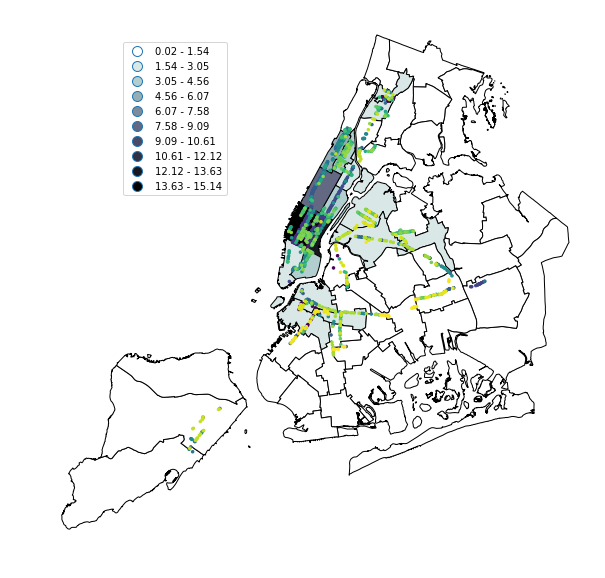

In [57]:
#plot the linkNYC locations on top of a choropleth of number of stations per 100 people  in 10 equal intervals
algo,eje,figurita=cp.choroplethNYC(pumashplc, column="linkNYCp100p", color="white",cmap="bone_r", edgecolor="black", scheme='equal_interval',k=10,lw=1)
cp.choroplethNYC(linkNYC_,ax=eje,cmap="viridis");


Figure 4. Number of stations by 100 people and LinkNYC stations. Note that doing equal intervals, most of the areas have less than 1. Again, we see a pattern where many are concentrated in Manhattan

# Extra credit 1: 
How would you enhance the visibility of this map? you are working with numbers that are mostly very low, and reside near each other, and them have a few much higher value points. Notice that here the high values are interesting though and should not be thrown away!

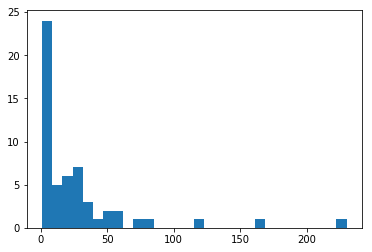

In [58]:
plt.hist(pumashplc["count_link"], bins=30);

One way to deal with this type of aggregation is using quantiles instead of equal intervals. As we saw in the .describe() above, the mean of LinkNYC is 1.5 and 75% have less than 2. This will solve the problem of very low values concentrated and could make a better graph.

This idea was suggested on the following source:
source=https://ocefpaf.github.io/python4oceanographers/blog/2015/08/24/choropleth/

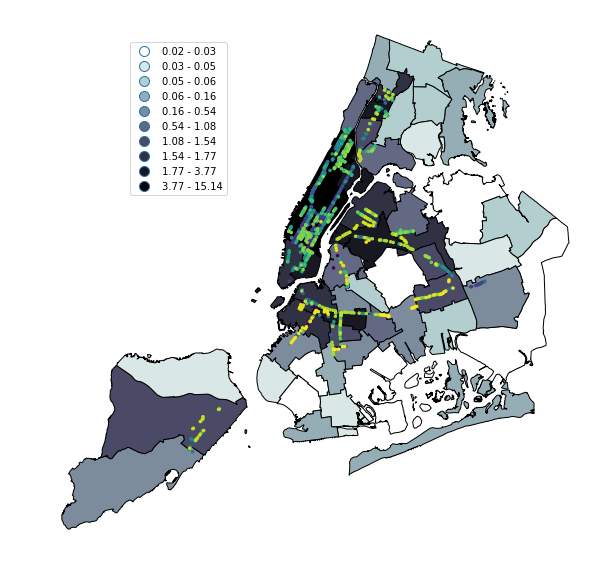

In [59]:
#Plotting with quantiles
algo,eje,figurita=cp.choroplethNYC(pumashplc, column="linkNYCp100p", color="white",cmap="bone_r", edgecolor="black", scheme='quantiles',k=10,lw=1)
cp.choroplethNYC(linkNYC_,ax=eje,cmap="viridis");

Fig 5. Plotting the same data but with quantiles. Note that now many more areas are colored with thing other than white.
We can see the same pattern as before, concentration in Manhattan, but now we can distinguish between areas that also have significance difference between each other.

## Extra Credit 2:
plot Spatial Lag Deciles that describe the impact of linkNYC in providing access where needed. You can follow what you did in the lab, but you need to create a metric based on the data you have tha measures the impact of linkNYC


this is whay I came up with, and needs not be the same for you. But properly describe what you obtain


Note: To find the table you extracted through the API manually you could

https://factfinder.census.gov/ -> Advanced Search -> Show me all 
    
    - Topics: Housing -> Physical Characteristics -> Internet Access
    - Geographies -> all geography types -> Public Use Microdata Areas (755)
                     -> Select a State: New York -> All Pubic Use Microdaa Areas within New York
                     -> Add Your Selection
    - Years -> 2016